# **CSE 6242: Data and Visual Analytics**
## *Prediction Section: Facebook Prophet*


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Change path if needed
%cd "drive/MyDrive/dataviz_project"

/content/drive/MyDrive/dataviz_project


### Libraries import and data loading

In [ ]:
import logging
import time

import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from IPython.display import display
from multiprocessing import Pool, cpu_count

### Dataset with timeline

In [ ]:
df_acc = pd.read_csv('./GA_Accidents_March23.csv', usecols = ["ID", "Start_Time"])
df_acc["Start_Time"] = pd.to_datetime(df_acc["Start_Time"], format='%Y-%m-%d %H:%M:%S', errors='coerce')

timestamp_objects = [pd.Timestamp(date_str) for date_str in df_acc["Start_Time"]]
first_date = min(timestamp_objects)
last_date = max(timestamp_objects)
print(f"First date: {first_date}")
print(f"Last date: {last_date}")

df_acc.head()

First date: 2016-06-17 15:03:10
Last date: 2023-03-31 22:47:00


,ID,Start_Time
0,A-146262,2016-11-30 15:13:44
1,A-146263,2016-11-30 15:25:27
2,A-146264,2016-11-30 14:42:27
3,A-146265,2016-11-30 16:27:58
4,A-146266,2016-11-30 16:14:20


### Matched street accidents

In [ ]:
edges = pd.read_json('./edges_matched_final.json')

### Original dataset

In [ ]:
pre_edges = pd.read_csv('./edges.csv')

In [ ]:
pre_edges.head()

,id,osm_id,source,target,length,foot,car_forward,car_backward,bike_forward,bike_backward,train,wkt
0,6252596-0,6252596,52374104,52374110,119.120733,Allowed,Residential,Residential,Allowed,Allowed,Forbidden,"LINESTRING(-85.1936440 32.8709280, -85.1936430..."
1,6252604-0,6252604,52374332,52374353,508.980175,Allowed,Residential,Residential,Allowed,Allowed,Forbidden,"LINESTRING(-85.3800910 32.8897580, -85.3803420..."
2,6252612-0,6252612,52374420,52374433,405.555027,Allowed,Residential,Residential,Allowed,Allowed,Forbidden,"LINESTRING(-85.1991900 32.8642800, -85.1995780..."
3,6252612-1,6252612,52374433,52374434,103.451836,Allowed,Residential,Residential,Allowed,Allowed,Forbidden,"LINESTRING(-85.2035250 32.8643820, -85.2046310..."
4,6252612-2,6252612,52374434,52374436,55.739309,Allowed,Residential,Residential,Allowed,Allowed,Forbidden,"LINESTRING(-85.2046310 32.8644070, -85.2047770..."


# Functions definition

In [ ]:
def run_prophet(df):
  '''
  Prophet model running for a given time serie in a DataFrame
  '''
  # Initialize the Prophet model
  model = Prophet(interval_width=0.8,
                  uncertainty_samples=50)
  model.fit(df)
  future = model.make_future_dataframe(periods=10, freq='M')
  forecast = model.predict(future)

  return max(forecast["trend"].iloc[-1], 0)


def process_route_group(route_group):
  '''
  Prophet running by groups for cpu boost
  '''
  return route_group.groupby('routes', group_keys=False).apply(lambda group: run_prophet(group)).to_frame(name="E_nb_acc")


def new_length(road, p):
  '''
  Safety index calculation
  '''
  return road["length"]*(1 + road["nb_acc"])**p

# Data preprocessing

### Select edges with accidents

In [ ]:
edges_T = edges.T
edges_T["nb_acc"] = edges_T["acc"].apply(lambda x: len(x))
edges_T = edges_T[edges_T["nb_acc"] > 0]

In [ ]:
edges_T.head()

,src,tar,acc,nb_acc
6308121-0,"[-85.2855711, 33.9970822]","[-85.287049, 33.995275]","[A-3785240, A-5039498]",2
6308121-2,"[-85.2880064, 33.9940776]","[-85.28859969999999, 33.9933355]","[A-3790710, A-4289670]",2
6308121-8,"[-85.291534, 33.989689]","[-85.29163849999999, 33.9895599]",[A-4919156],1
8225862-0,"[-84.2644787, 34.0829179]","[-84.262315, 34.0861419]","[A-2085663, A-2103175, A-2161625, A-2254248, A...",30
9006256-0,"[-83.3745402, 32.9989002]","[-83.378711, 33.008328]",[A-7618314],1


### Reverse routes and accidents

In [ ]:
street_dict = edges_T["acc"].to_dict()

acc_dict = {}
for key, values in street_dict.items():
    for value in values:
        if value in acc_dict:
            acc_dict[value].append(key)
        else:
            acc_dict[value] = [key]

In [ ]:
df_acc_route = pd.DataFrame.from_dict(acc_dict, orient='index', columns=["routes"])
df_acc_route.head()

,routes
A-3785240,6308121-0
A-5039498,6308121-0
A-3790710,6308121-2
A-4289670,6308121-2
A-4919156,6308121-8


### Join with accidents dataset

In [ ]:
df_acc_copy = df_acc.copy()
df_acc_copy.set_index("ID", inplace=True)
df_acc_copy["Start_Time"] = pd.to_datetime(df_acc_copy["Start_Time"], format='%Y-%m-%d %H:%M:%S', errors='coerce')
df_acc_copy.head()

,Start_Time
ID,
A-146262,2016-11-30 15:13:44
A-146263,2016-11-30 15:25:27
A-146264,2016-11-30 14:42:27
A-146265,2016-11-30 16:27:58
A-146266,2016-11-30 16:14:20


In [ ]:
df_prophet = df_acc_route.merge(df_acc_copy, how="inner", left_index=True, right_index=True)
df_prophet = df_prophet.groupby(["routes", "Start_Time"]).size().reset_index(name="nb_acc")

df_prophet['year_month'] = df_prophet['Start_Time'].dt.to_period('M')
df_prophet['year_month'] = df_prophet['year_month'].dt.to_timestamp()

df_prophet = df_prophet.groupby(["routes", "year_month"])['nb_acc'].sum().reset_index()
df_prophet.head()

,routes,year_month,nb_acc
0,1000478390-0,2017-12-01,2
1,1000478390-0,2018-08-01,1
2,1000478390-0,2018-09-01,1
3,1000478390-0,2019-05-01,1
4,1000970663-1,2019-03-01,1


### Rename variables for Prophet

In [ ]:
df_prophet.rename(columns={"year_month":"ds", "nb_acc":"y"}, inplace=True)
df_prophet.head()

,routes,ds,y
0,1000478390-0,2017-12-01,2
1,1000478390-0,2018-08-01,1
2,1000478390-0,2018-09-01,1
3,1000478390-0,2019-05-01,1
4,1000970663-1,2019-03-01,1


### Filling missing dates with 0

In [ ]:
unique_routes = df_prophet['routes'].unique()

date_range = pd.date_range(start='2016-06', end='2023-03', freq='MS')
date_range = pd.to_datetime(date_range, format='%Y-%m')

all_combinations = pd.DataFrame([(route, month) for route in unique_routes for month in date_range],
                                 columns=['routes', 'ds'])
all_combinations['ds'] = pd.to_datetime(all_combinations['ds'])

df_prophet = pd.merge(all_combinations, df_prophet, on=['routes', 'ds'], how='left').fillna(0)
df_prophet.head()

,routes,ds,y
0,1000478390-0,2016-06-01,0.0
1,1000478390-0,2016-07-01,0.0
2,1000478390-0,2016-08-01,0.0
3,1000478390-0,2016-09-01,0.0
4,1000478390-0,2016-10-01,0.0


# Prophet setup and training

In [ ]:
print(len(unique_routes))

19390


As there are many roads with accidents, let's make a first try on a few examples.

In [ ]:
test_prophet = df_prophet[df_prophet["routes"].isin(unique_routes[:100])]
route_groups = [group for _, group in test_prophet.groupby('routes')]

### Comparison between CPU boosting and general running

In [ ]:
logging.getLogger("cmdstanpy").disabled = True

start_time = time.time()
result = test_prophet.groupby('routes', group_keys=False).apply(lambda group: run_prophet(group)).to_frame(name="E_nb_acc")
print("--- %s seconds ---" % (time.time() - start_time))

logging.getLogger("cmdstanpy").disabled = False

Without CPU boost: 27 seconds.

In [ ]:
logging.getLogger("cmdstanpy").disabled = True
p = Pool(cpu_count())

start_time = time.time()
result_list = p.map(process_route_group, route_groups)
p.close()
p.join()
print("--- %s seconds ---" % (time.time() - start_time))

logging.getLogger("cmdstanpy").disabled = False

With CPU boost: 24 seconds.

Let's use the CPU boost for all time series.

In [ ]:
full_route_groups = [group for _, group in df_prophet.groupby('routes')]

logging.getLogger("cmdstanpy").disabled = True
p = Pool(cpu_count())

start_time = time.time()
result_list = p.map(process_route_group, full_route_groups)
p.close()
p.join()
print("--- %s seconds ---" % (time.time() - start_time))

logging.getLogger("cmdstanpy").disabled = False

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet

--- 5326.63821554184 seconds ---


In [ ]:
acc_dict_final = dict()

for x in result_list:
  acc_dict_final[x.index[0]] = x["E_nb_acc"][0]

final_result = pd.DataFrame.from_dict(acc_dict_final, orient='index', columns=["nb acc"])

In [ ]:
final_result.head()

,id,nb_acc
0,1000478390-0,0.000000
1,1000970663-1,0.000000
2,1001085282-0,0.104225
3,1001112518-0,0.020421
4,1001112568-0,0.489053


Let's now save the dataset to not have to run the accident estimation again.

In [ ]:
final_result.to_csv("estimated_nb_acc.csv")

# Final lengths calculation based on the safety index

### Data loading

In [ ]:
final_result = pd.read_csv("./estimated_nb_acc.csv", names=["id", "nb_acc"], header=None, skiprows=1)

In [ ]:
new_edges = final_result.merge(pre_edges.set_index("id"), how="outer", on="id")
new_edges.fillna(0, inplace=True)
new_edges.head()

,id,nb_acc,osm_id,source,target,length,foot,car_forward,car_backward,bike_forward,bike_backward,train,wkt
0,1000478390-0,0.000000,1000478390,9235038770,9235038764,11.653614,Allowed,Residential,Forbidden,Allowed,Forbidden,Forbidden,"LINESTRING(-84.3679563 33.8471358, -84.3680255..."
1,1000970663-1,0.000000,1000970663,5415070247,5415069969,10.094675,Allowed,Primary,Primary,Allowed,Allowed,Forbidden,"LINESTRING(-84.5399110 33.5687914, -84.5398104..."
2,1001085282-0,0.104225,1001085282,9240519210,8820939626,101.007191,Forbidden,Motorway,Forbidden,Forbidden,Forbidden,Forbidden,"LINESTRING(-84.3994164 33.6216405, -84.3995062..."
3,1001112518-0,0.020421,1001112518,8916074539,9240768881,15.632729,Forbidden,Motorway,Forbidden,Forbidden,Forbidden,Forbidden,"LINESTRING(-84.5113953 33.5852582, -84.5113056..."
4,1001112568-0,0.489053,1001112568,549931624,68348195,79.339160,Forbidden,Motorway,Forbidden,Forbidden,Forbidden,Forbidden,"LINESTRING(-84.2514467 33.8132674, -84.2513640..."


### Choice of p-value

In [ ]:
p_values = [1.25, 1.5, 1.75, 2, 2.5]

for p in p_values:
    column_name = f"length_gabriel_{p}"
    new_edges[column_name] = new_edges.apply(lambda x: new_length(x, p=p), axis=1)

In [ ]:
new_edges[new_edges["nb_acc"] > 0][["length", "nb_acc", "length_gabriel_1.25", "length_gabriel_1.5", "length_gabriel_1.75", "length_gabriel_2", "length_gabriel_2.5" ]]

,length,nb_acc,length_gabriel_1.25,length_gabriel_1.5,length_gabriel_1.75,length_gabriel_2,length_gabriel_2.5
2,101.007191,0.104225,114.333714,117.202997,120.144286,123.159388,129.418491
3,15.632729,0.020421,16.032785,16.114017,16.195660,16.277716,16.443079
4,79.339160,0.489053,130.504390,144.162607,159.250253,175.916930,214.665695
5,10.831962,0.065419,11.724866,11.912093,12.102309,12.295562,12.691376
7,27.885837,0.019561,28.569339,28.708037,28.847408,28.987455,29.269594
...,...,...,...,...,...,...,...
19382,33.082973,0.080577,36.448048,37.161071,37.888043,38.629236,40.155406
19383,101.639266,0.030250,105.496902,106.285824,107.080646,107.881411,109.500952
19385,55.100220,0.589363,98.329128,110.404801,123.963472,139.187265,175.473301
19388,264.162199,0.019561,270.637004,271.950886,273.271147,274.597817,277.270510


In [ ]:
w_acc_curr = 100
p_values = [1.25, 1.5, 1.75, 2, 2.5]
nb_acc_pred = np.linspace(0, 10, 100)

fig = go.Figure()
fig.update_layout(title='Single Plot for Different Values of p')

for p in p_values:
    nb_acc_new = w_acc_curr*((1 + nb_acc_pred)**p)
    fig.add_trace(go.Scatter(x=nb_acc_pred, y=nb_acc_new, mode='lines', name=f'p = {p}'))

fig.update_layout(xaxis_title='nb_acc_pred', yaxis_title='nb_acc_new', showlegend=True, autosize=False,
    width=1000,
    height=700)

fig.show()


Let's take $p=2$, which seems to penalize roads with a high number of estimated accidents without giving inconsistent values like for $p=2.5$

In [ ]:
new_edges.drop(columns=["length_gabriel_1.25", "length_gabriel_1.5", "length_gabriel_1.75", "length_gabriel_2.5"], inplace=True)
new_edges.rename({"length_gabriel_2": "length_gabriel"}, inplace=True)

In [ ]:
new_edges.to_csv("new_edges_dataset.csv")

# A Prophet plot

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


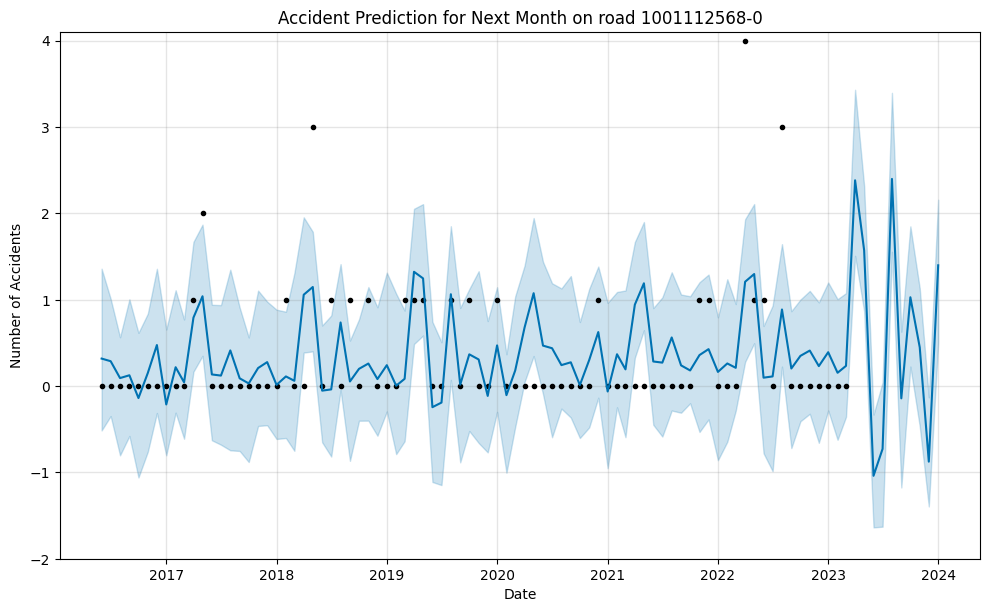

In [ ]:
# Road id
road_id = "1001112568-0"

# Initialize the Prophet model
logging.getLogger("cmdstanpy").disabled = True
model = Prophet(interval_width=0.8,
                uncertainty_samples=50)

# Fit the model
model.fit(df_prophet[df_prophet["routes"]==road_id])

# Create a dataframe with dates for the next month
future = model.make_future_dataframe(periods=10, freq='M')

# Make predictions
forecast = model.predict(future)
logging.getLogger("cmdstanpy").disabled = False

plt.figure(dpi=300)
# Plot the forecast
fig = model.plot(forecast)
plt.title(f'Accident Prediction for Next Month on road {road_id}')
plt.xlabel('Date')
plt.ylim(-2, 4.1)
plt.ylabel('Number of Accidents')
plt.show()